In [3]:
import random

import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn
import tensorflow as tf
from tensorflow import keras as k
import sounddevice as sd
import uuid
import json
import math
from time import sleep

In [29]:
def record(record_number = 10, count = 0, fs = 44100, duration = 2, meta_data_file = 'data/sound/meta.txt', label = 'one',mode='w'):

    meta_data = {}

    f = open(meta_data_file, mode=mode)

    #collect n number of samples
    for i in range (record_number):
        print ("Recording in 2...")
        sleep(1)
        print ("Recording in 1...")
        sleep(1)
        print ("Recording...")
        f_name = str(count)

        meta_data['id'] = uuid.uuid4().hex
        meta_data['sampling_rate'] = fs
        meta_data['duration'] = duration
        meta_data['file_name'] = str(count) + '.npy'
        meta_data['label'] = label

        #sample data from mic
        val = sd.rec(frames=fs*duration, samplerate=fs, channels=1)
        sd.wait()

        # transform obj to string
        meta_json_data = json.dumps(meta_data)
        f.write(meta_json_data + '\n')


        np.save('data/sound/'+f_name+'.npy',val)

        count += 1
        print ("Recording...Done")
        print('meta info:', meta_data)

    f.close()
    print ("Recording...Done")

In [5]:
def data_loader(file_name):
    f = open(file_name,'r')

    data = []
    lines = f.readlines()

    for l in lines:
        obj_data = json.loads(l)
        data.append(obj_data)

    f.close()
    return data

In [110]:
# helper from integer to categorical
def int2cat(int_label, nr_outputs=3):

    #[0,0,0]
    arr = np.zeros(nr_outputs)
    arr[int(int_label)] = 1

    return arr

In [196]:
def data2fftimge(data):
    _,_,_,img = plt.specgram(data.flatten(),NFFT=256,Fs=fs,scale_by_freq=False, noverlap=64)

    img_2d = img.make_image(None)[0][...,0:3]

    return img_2d



In [188]:
label_transform_dict = {
    'left': 0,
    'right': 2,
    'other': 1,
}
class cDataLoader(tf.keras.utils.Sequence):

    def __init__(self, data, batch_size=8, shuffle=True, label_dict = label_transform_dict, data_path='data/sound/'):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data = np.array(data)
        self.label_dict = label_dict
        self.data_path = data_path


    def __len__(self):
        return math.ceil(len(self.data)/self.batch_size)

    def __getitem__(self, idx):
        batch_data = self.data[idx* self.batch_size:(idx+1)*self.batch_size]


        X = []
        y = []
        for batch in batch_data:
            #upload the sound data
            val = np.load(self.data_path+batch['file_name'])

            #transform data to img
            val = data2fftimge(val)
            label = batch['label']

            #label conversion to categorical
            X.append(val)
            y.append(int2cat(int(label_transform_dict[label])))

        X = np.array(X)
        y = np.array(y)


        return X, y

    def on_epoch_end(self):

        if self.shuffle:
            np.random.shuffle(self.data)


In [7]:
record(record_number=20,label='right')


Recording in 3....
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '06b50fd08e9f4a71ba465a14a4614525', 'sampling_rate': 44100, 'duration': 2, 'file_name': '0.npy', 'label': 'right'}
Recording in 3....
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '8a629edde8d745a4a719f80d4712140a', 'sampling_rate': 44100, 'duration': 2, 'file_name': '1.npy', 'label': 'right'}
Recording in 3....
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': 'c857e3374df6419b86033e3f60df31cc', 'sampling_rate': 44100, 'duration': 2, 'file_name': '2.npy', 'label': 'right'}
Recording in 3....
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '480effa117344ce68393559dfc21323b', 'sampling_rate': 44100, 'duration': 2, 'file_name': '3.npy', 'label': 'right'}
Recording in 3....
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '675079d5507842cba9fdf4ac

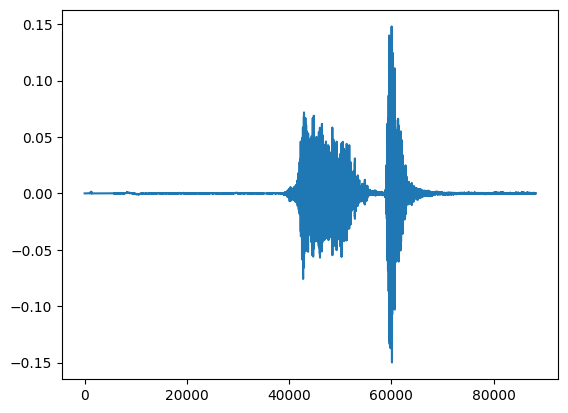

In [23]:
val = np.load('data/sound/11.npy')
plt.plot(val)

In [30]:
record(record_number=80,label='right',count=20,mode='a')


Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '4547940abdcf4f6188b00497655c0072', 'sampling_rate': 44100, 'duration': 2, 'file_name': '20.npy', 'label': 'right'}
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '2b8b0f05c4ee46089ab0c0ad61b72480', 'sampling_rate': 44100, 'duration': 2, 'file_name': '21.npy', 'label': 'right'}
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '94b0514ade7c43eeb2f2c8443cfb36a7', 'sampling_rate': 44100, 'duration': 2, 'file_name': '22.npy', 'label': 'right'}
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': 'c9285a5536c347a3a44d195296193e0d', 'sampling_rate': 44100, 'duration': 2, 'file_name': '23.npy', 'label': 'right'}
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': 'b3659d06156e4615baf903fe039d4f40', 'sampling_rate': 44100, 'duration': 2, 'file_name': '24.npy', 'label': 'right'}


In [ ]:
val = np.load('data/sound/92.npy')
plt.plot(val)


In [34]:
record(record_number=100,label='left',count=100,mode='a')


Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '1c23345681d24d7e9e781cc54326df1f', 'sampling_rate': 44100, 'duration': 2, 'file_name': '100.npy', 'label': 'left'}
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '46fa5c6cfb1b42c7a8ad6269ace802d0', 'sampling_rate': 44100, 'duration': 2, 'file_name': '101.npy', 'label': 'left'}
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '3c80a6bbc3d44ce08d98f72b3fe9e765', 'sampling_rate': 44100, 'duration': 2, 'file_name': '102.npy', 'label': 'left'}
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': 'c64dbba37c7d405096810643f3a50953', 'sampling_rate': 44100, 'duration': 2, 'file_name': '103.npy', 'label': 'left'}
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '20211b5f8ff545738fcbc16e444a950a', 'sampling_rate': 44100, 'duration': 2, 'file_name': '104.npy', 'label': 'left'}


In [39]:
record(record_number=1,label='left',count=198,mode='a')


Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '95c0fcdb206140348103c8cecca2ce70', 'sampling_rate': 44100, 'duration': 2, 'file_name': '198.npy', 'label': 'left'}
Recording...Done


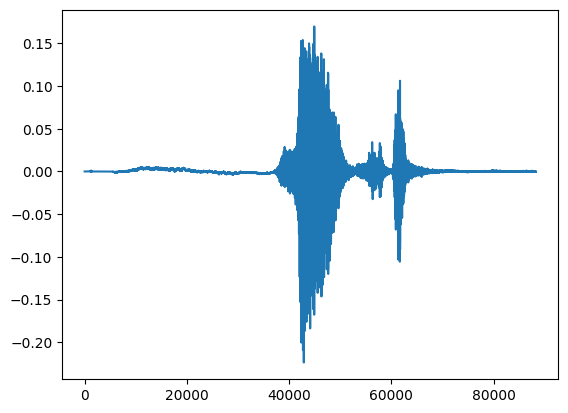

In [40]:
val = np.load('data/sound/198.npy')
plt.plot(val)

In [41]:
record(record_number=10, label='other',count=200,mode='a')


Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '37de06e0157344ff86a0e5e29fa57738', 'sampling_rate': 44100, 'duration': 2, 'file_name': '200.npy', 'label': 'other'}
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '9a23a60950564262957edd3ac7ffdc8f', 'sampling_rate': 44100, 'duration': 2, 'file_name': '201.npy', 'label': 'other'}
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '531a8c7e59064b6ebe11f0baa97c38b9', 'sampling_rate': 44100, 'duration': 2, 'file_name': '202.npy', 'label': 'other'}
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '0ab36601768943bb9612669ecf1eab30', 'sampling_rate': 44100, 'duration': 2, 'file_name': '203.npy', 'label': 'other'}
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': 'f9567b4441124b9398a447b12f45e280', 'sampling_rate': 44100, 'duration': 2, 'file_name': '204.npy', 'label': 'oth

In [42]:
record(record_number=1,label='left',count=201,mode='a')


Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '7cf8488ce40a42daac8f75fc4742ba8e', 'sampling_rate': 44100, 'duration': 2, 'file_name': '201.npy', 'label': 'left'}
Recording...Done


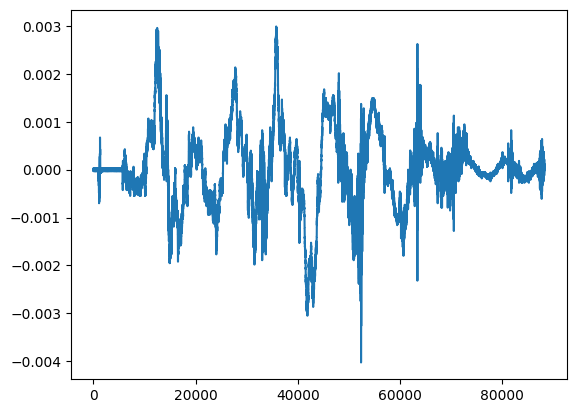

In [49]:
val = np.load('data/sound/209.npy')
plt.plot(val)

In [50]:
record(record_number=90,label='left',count=210,mode='a')


Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': 'f59c457fbb3b42dfb1c589acf47ea0d4', 'sampling_rate': 44100, 'duration': 2, 'file_name': '210.npy', 'label': 'left'}
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '593b4ef739a84d3e807a57290d53aac7', 'sampling_rate': 44100, 'duration': 2, 'file_name': '211.npy', 'label': 'left'}
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': 'b6571889278f4691ae526fa23a3115c7', 'sampling_rate': 44100, 'duration': 2, 'file_name': '212.npy', 'label': 'left'}
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': 'd320a337244349e0960cab9121a7e587', 'sampling_rate': 44100, 'duration': 2, 'file_name': '213.npy', 'label': 'left'}
Recording in 2...
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '2cc66b16171443ae8d201a06aeecf198', 'sampling_rate': 44100, 'duration': 2, 'file_name': '214.npy', 'label': 'left'}


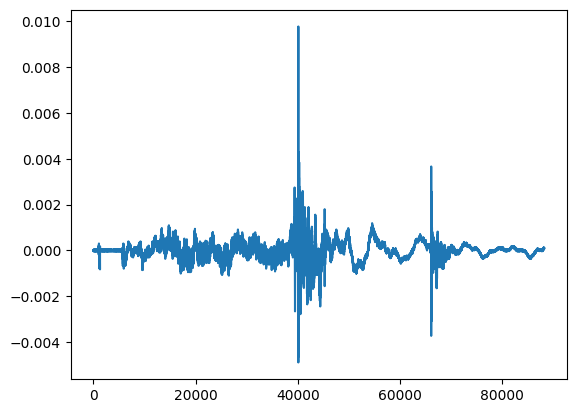

In [54]:
val = np.load('data/sound/275.npy')
plt.plot(val)

In [175]:
data = data_loader('data/sound/meta.txt')


In [59]:
print(data[290])

{'id': 'ddaa298a0ab34d4e9ebe2e11716c2299', 'sampling_rate': 44100, 'duration': 2, 'file_name': '290.npy', 'label': 'other'}


In [198]:

# mix the data

np.random.shuffle(data)
obj_data = cDataLoader(data,1,shuffle=True)
train, test, validation = np.split(data, [int(len(data)*0.7),int(len(data)*0.8)])
obj_train = cDataLoader(train,shuffle=True)
obj_val = cDataLoader(validation,shuffle=True)
obj_test = cDataLoader(test,shuffle=True)

print(len(train),len(validation),len(test))

210 60 30


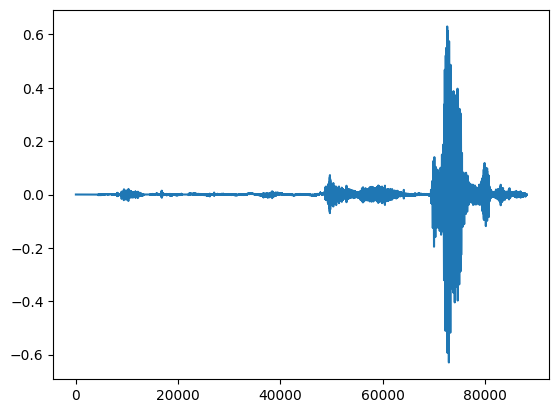

In [63]:
fs = 44100
duration = 2
val = sd.rec(frames=fs*duration, samplerate=fs, channels=1)
sd.wait()
plt.plot(val)

### MODEL

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_input (InputLayer)     [(None, 370, 496, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 366, 492, 8)       608       
                                                                 
 conv2d_16 (Conv2D)          (None, 364, 490, 32)      2336      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 182, 245, 32)     0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 180, 243, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 121, 64)      0         
 2D)                                                      

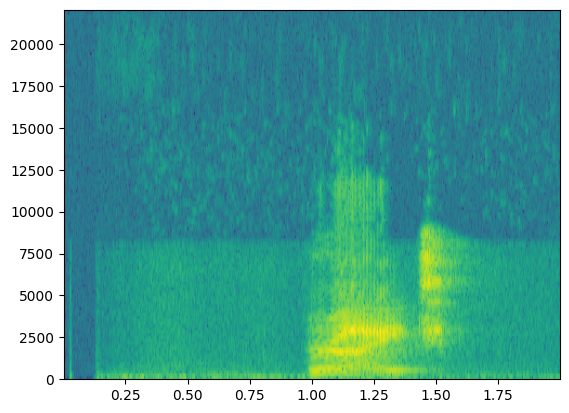

In [200]:
# Hyper-parameters
epochs = 1000
learning_rate = 0.0005
validation_split = 0.2
batch_size = 50
optimizer = k.optimizers.Adam(learning_rate=learning_rate)

sample_size = obj_data[1][0].shape
data_in = k.Input(shape =(sample_size[1],sample_size[2],sample_size[3]), name= "data_input")

val = k.layers.Conv2D(filters=8,kernel_size=(5,5),activation="relu")(data_in)

val = k.layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu")(val)

val = k.layers.MaxPool2D(pool_size=(2,2))(val)

val = k.layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu")(val)

val = k.layers.MaxPool2D(pool_size=(2,2))(val)

val = k.layers.Conv2D(filters=128,kernel_size=(3,3),activation="relu")(val)

val = k.layers.Flatten()(val)

val = k.layers.Dense(100,activation='relu')(val)

out = k.layers.Dense(units=3, name="out",activation='softmax')(val)

model1 = k.Model(inputs=data_in,outputs=out)
model1.compile(optimizer=optimizer,loss=k.losses.categorical_crossentropy,metrics=['accuracy'])


early_stopping = k.callbacks.EarlyStopping(monitor='val_loss', patience=2)
model1.summary()


Epoch 1/1000
 1/27 [>.............................] - ETA: 4:20 - loss: 6.8464 - accuracy: 0.6250

KeyboardInterrupt: 

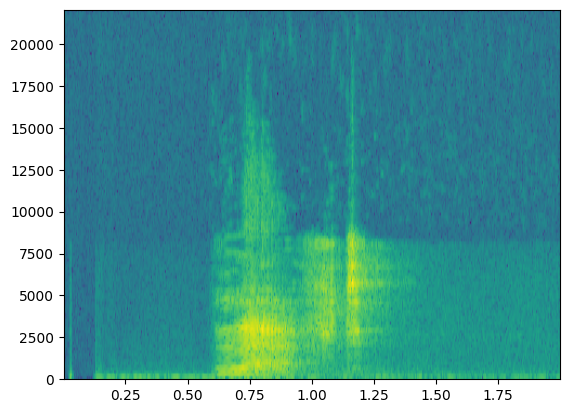

In [201]:
hist = model1.fit(x=obj_train,batch_size=batch_size, epochs=epochs, shuffle=True, validation_data=obj_val, callbacks=[early_stopping])
#Validation loss and training loss graphs
plt.plot(hist.history['loss'], c='b')
plt.plot(hist.history['val_loss'], c='r')
plt.show()
plt.plot(hist.history['accuracy'], c='b')
plt.plot(hist.history['val_accuracy'], c='r')

# DEMO HW
- use data loader and construct DNN for image classifcication
- track the acc, f1 score based on your input data, use augmenation if needed
- on the final demo, the results(confustion matrix) needed to be show, with real time data
- f1 score >= 80
- resnet